# Delivery Time Prediction Models

**Objective:** Develop and apply machine learning models to accurately predict delivery times in minutes.

### **Document structure**

1. **Data Preparation**
	- Import dataset, libraries and metrics
	- Splitting and scaling data
2. **Models Fitting and Tuning**
3. **Models Evaluating**
	- Key metrics
	- Residual and q-q plots
4. **Evaluate Selected Model on Test Data**
	- Key metrics and plots
	- Actual VS Predicted values
	- Feature importance

## Data Preparation

### Import dataset, libraries and metrics

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set_theme()

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as rmse, r2_score as r2

In [2]:
df = pd.read_csv(r"prep_data.csv").sample(50000)
df.head(10)

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,delivery_duration_min,is_weekend,hour,avg_item_price,...,month_January,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
138107,3,30.47,3,5.49,15.99,37.0,37.316667,0,2,10.16,...,1,0,0,0,1,0,0,0,0,1
6311,1,7.10,1,7.10,7.10,190.0,78.383333,0,2,7.10,...,0,1,0,0,0,0,0,0,0,1
78824,5,54.50,5,9.50,16.50,176.0,61.150000,1,3,10.90,...,0,0,0,1,0,0,0,0,0,1
130692,1,10.95,1,9.95,9.95,177.0,47.016667,1,2,10.95,...,0,0,1,0,0,0,0,0,0,1
134743,1,13.95,1,13.95,13.95,54.0,30.200000,0,4,13.95,...,0,0,0,0,0,0,1,0,0,1
63766,3,18.50,3,2.50,13.00,34.0,29.200000,0,1,6.17,...,1,0,0,0,0,0,0,0,0,1
86944,3,15.87,3,4.59,5.99,156.0,55.933333,1,2,5.29,...,0,0,1,0,0,0,0,0,0,1
84941,3,19.37,3,3.49,6.99,171.0,41.933333,1,3,6.46,...,0,0,0,1,0,0,0,0,0,1
29192,6,22.14,2,1.99,8.69,42.0,43.366667,1,2,3.69,...,1,0,0,1,0,0,0,0,0,1
93171,1,7.25,1,7.25,7.25,171.0,39.883333,0,3,7.25,...,0,0,0,0,0,0,0,0,0,1


### Splitting and scaling data

In [3]:
X = df.drop("delivery_duration_min", axis=1)
y = df["delivery_duration_min"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [4]:
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

## Models Fitting and Tuning
For each model, hyperparameters tuning was conducted to achieve the best results.

### Regularized Regression's

In [5]:
# hyperparameters
alpha_values = 10 ** np.linspace(-3, 3, 200)
l1_ratios = np.linspace(0.01, 1, 20)

lasso = LassoCV(alphas=alpha_values, cv=5, max_iter=10000, n_jobs=-1).fit(X_train_scale, y_train)
ridge = RidgeCV(alphas=alpha_values, cv=5).fit(X_train_scale, y_train)
elastic_net = ElasticNetCV(alphas=alpha_values, l1_ratio=l1_ratios, cv=5, max_iter=10000, n_jobs=-1).fit(X_train_scale, y_train)

### Decision Tree

In [6]:
tree_params = {
    "max_depth": [2, 4, 6, 8, 10, 14, 20, 24],
    "min_samples_leaf": [2, 5, 10, 20, 100],
    "min_samples_split": [2, 5, 10, 20]
}

grid_serach = GridSearchCV(DecisionTreeRegressor(random_state=123), tree_params, n_jobs=-1).fit(X_train_scale, y_train)

In [7]:
tree_best_params = grid_serach.best_params_
tree = DecisionTreeRegressor(**tree_best_params).fit(X_train_scale, y_train)

### Random Forest

In [8]:
forest_params = {
    "max_depth": [2, 4, 8, 14, 20],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10]
}

forest_model = RandomForestRegressor(n_jobs=-1, random_state=101)
random_search = RandomizedSearchCV(forest_model, forest_params, n_iter=25, n_jobs=-1).fit(X_train_scale, y_train)

In [9]:
forest_best_params = random_search.best_params_
forest = RandomForestRegressor(**forest_best_params).fit(X_train_scale, y_train)

### Gradient Boosting

In [10]:
gradient_params = {
    "n_estimators": [20, 40, 60, 80, 100, 200],
	"max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [2, 5, 10],
    "min_samples_split": [2, 5, 10, 20]
}

gradient_model = GradientBoostingRegressor(random_state=101)
gradient_search = RandomizedSearchCV(gradient_model, gradient_params, n_iter=30, n_jobs=-1).fit(X_train_scale, y_train)

In [12]:
gradient_best_params = gradient_search.best_params_
gradient = GradientBoostingRegressor(**gradient_best_params).fit(X_train_scale, y_train)

## Models Evaluating

In [13]:
# Function to display key metrics for model
def model_performance(model, X, y):
    r2_score = r2(y, model.predict(X)).round(3)
    mae_score = mae(y, model.predict(X)).round(3)
    rmse_score = rmse(y, model.predict(X), squared=False).round(3)
    
    data = {"R2": [r2_score], "MAE": [mae_score], "RMSE": [rmse_score]}
    return pd.DataFrame(data)

### Key metrics

In [28]:
frame = pd.DataFrame()
col_names = ["Ridge", "Lasso", "ElasticNet", "Decision Tree", "Random Forest", "Gradient Boosting"]

for model in [ridge, lasso, elastic_net, tree, forest, gradient]:
    frame = pd.concat([frame, model_performance(model, X_train_scale, y_train)])

model_name = pd.DataFrame(col_names, columns=["model"])
output = pd.concat([model_name, frame.reset_index(drop=True)], axis=1)

In [29]:
output.sort_values("R2", ascending=False)

,model,R2,MAE,RMSE
4,Random Forest,0.535,8.721,12.856
5,Gradient Boosting,0.379,10.194,14.852
3,Decision Tree,0.254,11.217,16.282
0,Ridge,0.208,11.541,16.774
1,Lasso,0.208,11.542,16.775
2,ElasticNet,0.208,11.542,16.775


### Residual and q-q plots

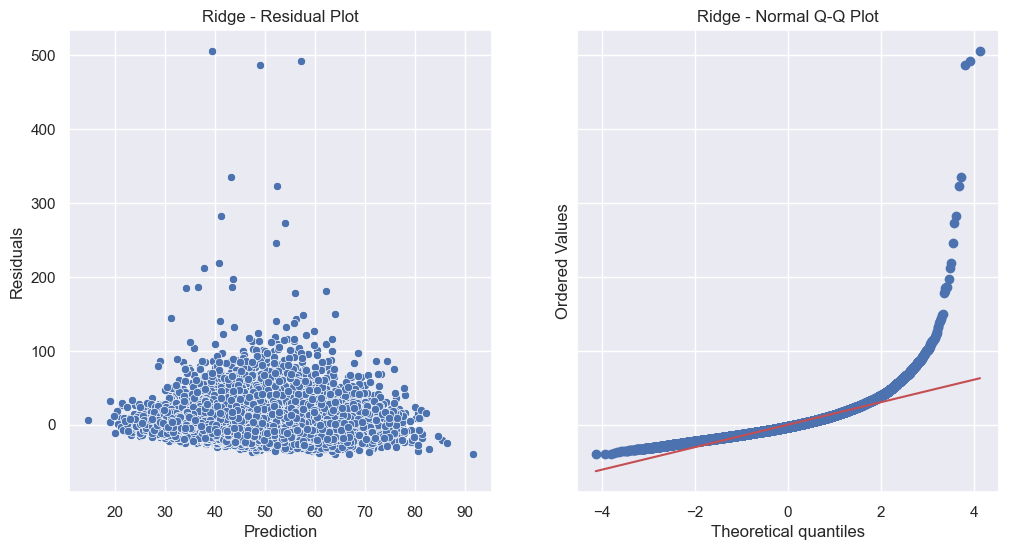

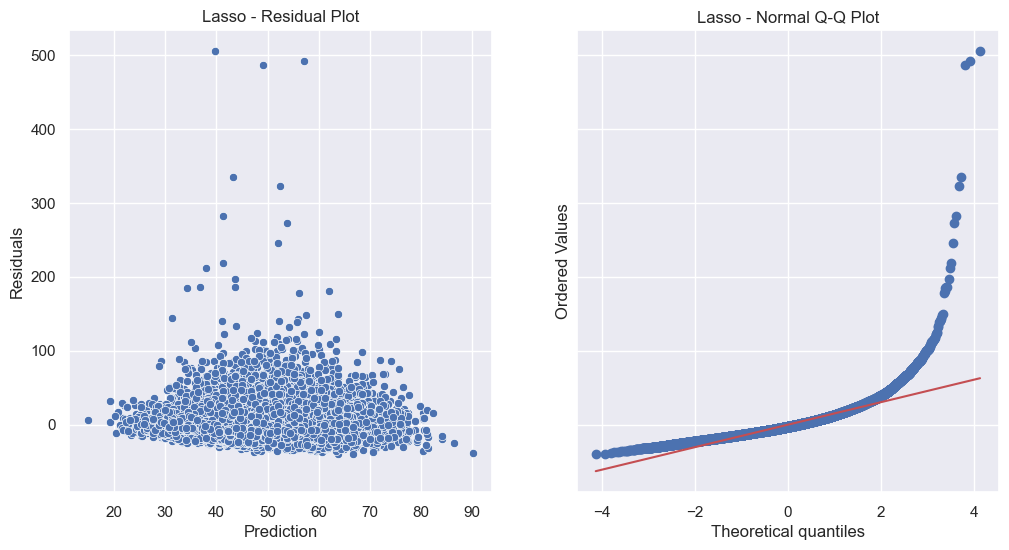

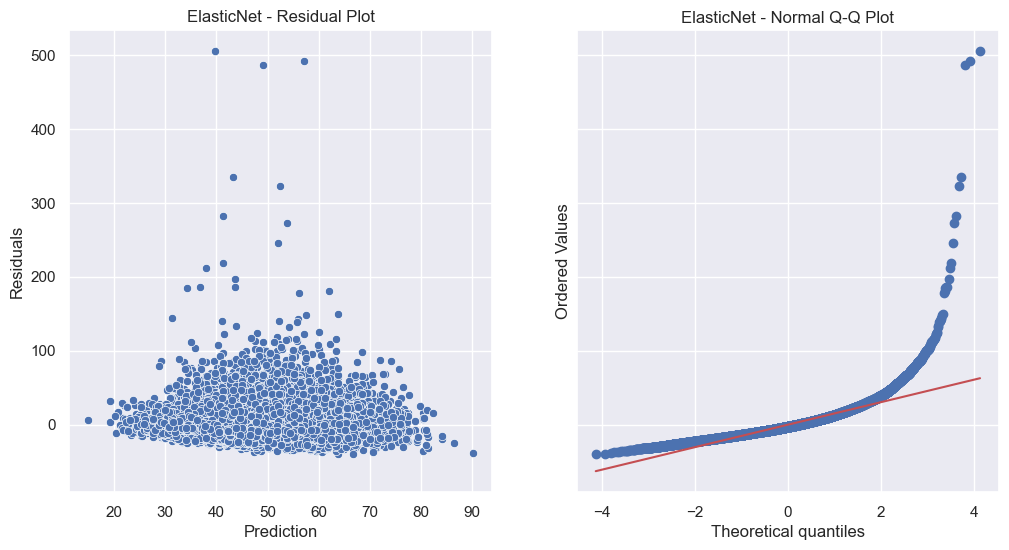

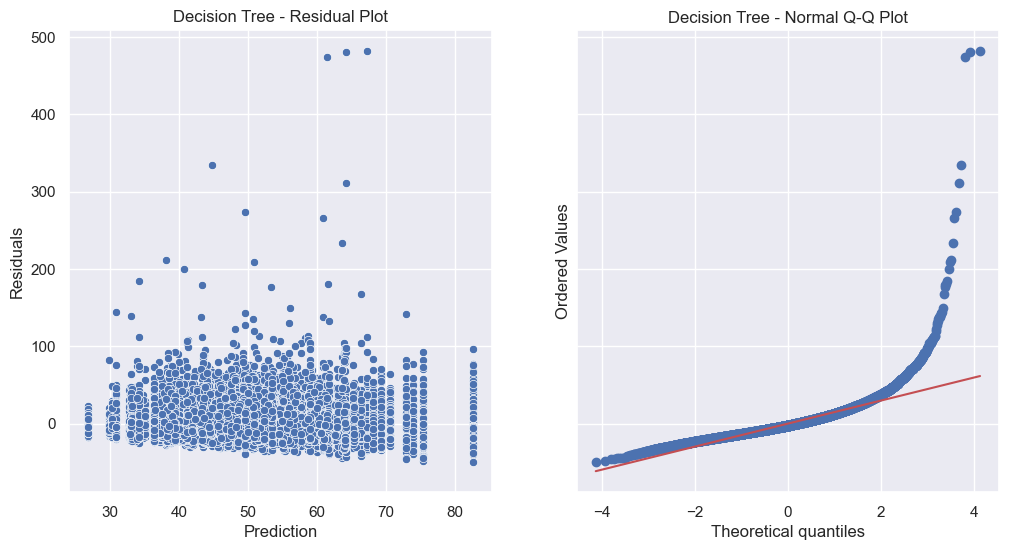

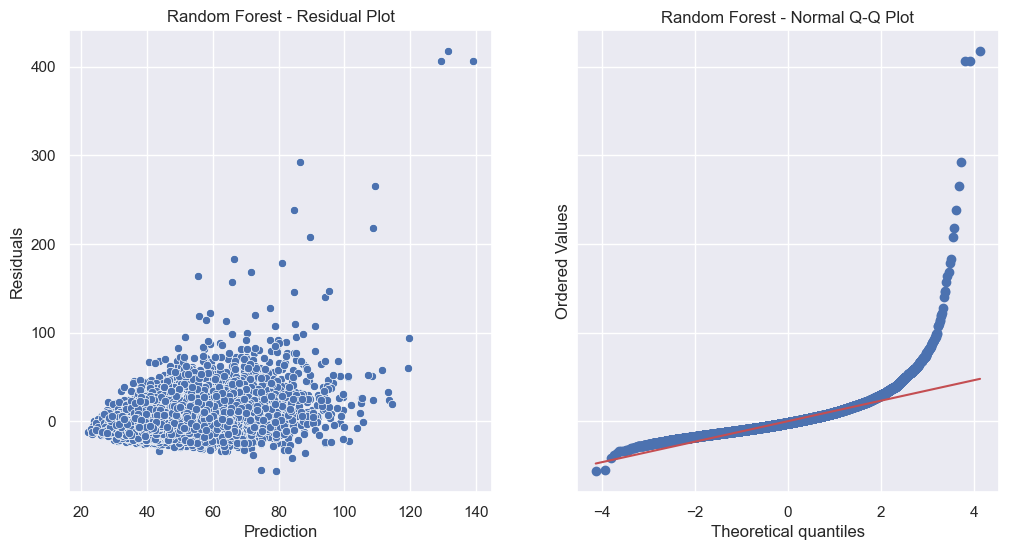

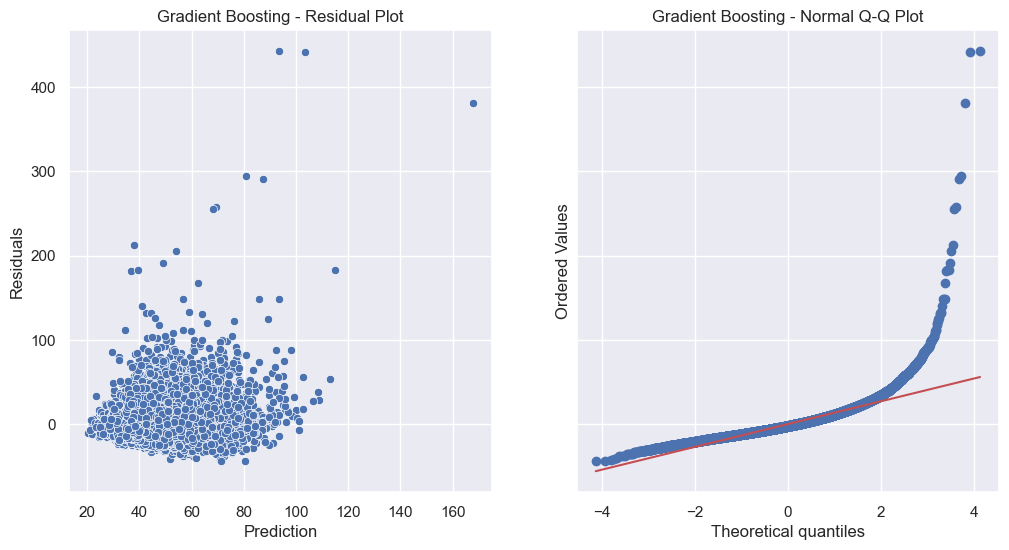

In [57]:
# Code to display residual and q-q plots for each model

for i, model in enumerate([ridge, lasso, elastic_net, tree, forest, gradient]):
    predictions = model.predict(X_train_scale)
    residuals = y_train - predictions
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(12, 6))

    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title(f"{col_names[i]} - Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")

    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title(f"{col_names[i]} - Normal Q-Q Plot")

    plt.show();

## Evaluate Selected Model on Test Data

### Key metrics and plots
The mean absolute error (MAE) for our model is ~10 minutes. This is a common and realistic result for delivery scenarios in the real world, indicating that the model performs well within expected parameters. If add more hyperparameters for each model and access the entire dataset instead of just 50,000 rows, the results could be even better.

In [40]:
model_performance(gradient, X_test_scale, y_test)

,R2,MAE,RMSE
0,0.302,10.864,15.217


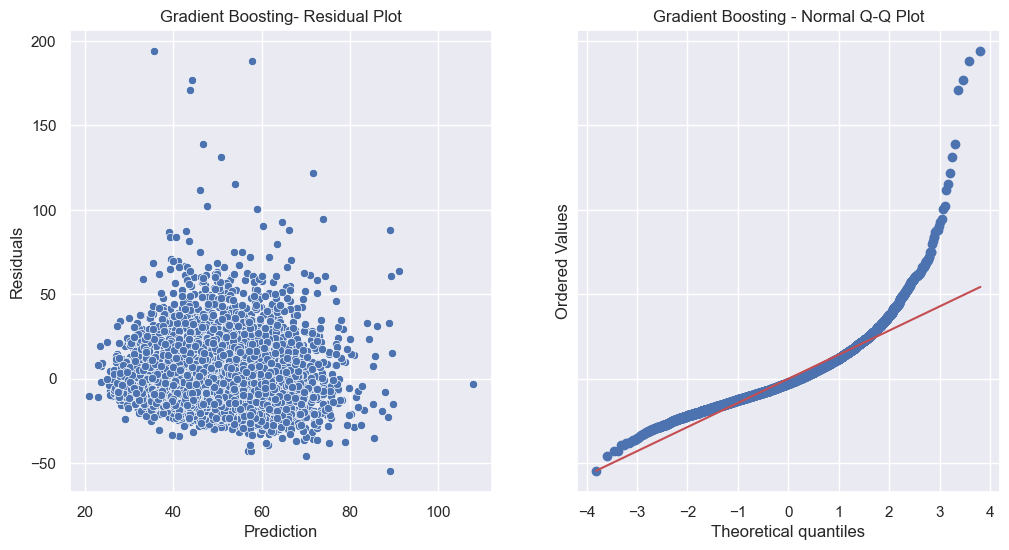

In [55]:
predictions = gradient.predict(X_test_scale)
residuals = y_test - predictions
fig, ax = plt.subplots(1, 2, sharey="all", figsize=(12, 6))

sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
ax[0].set_title(f"Gradient Boosting- Residual Plot")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Residuals")

stats.probplot(residuals, dist="norm", plot=ax[1])
ax[1].set_title(f"Gradient Boosting - Normal Q-Q Plot")

plt.show();

### Actual VS Predicted Values

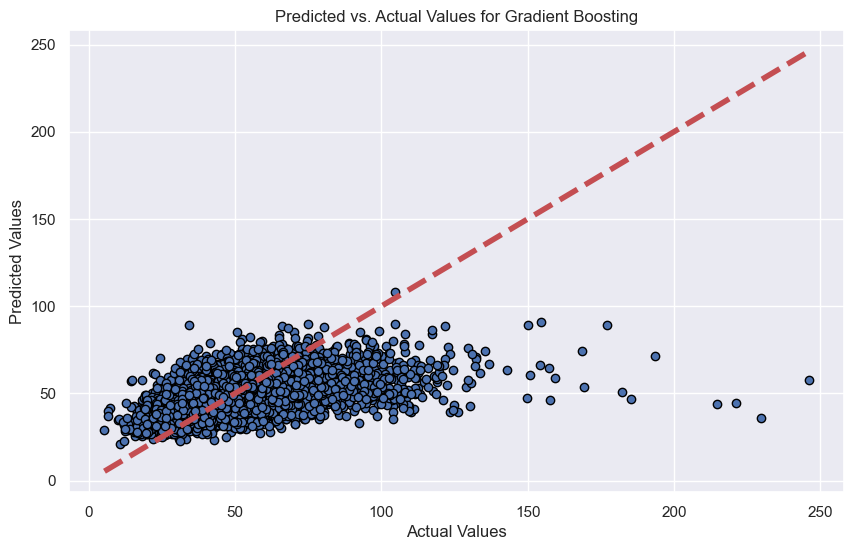

In [54]:
y_pred = gradient.predict(X_test_scale)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=4)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values for Gradient Boosting")
plt.show();

### Feature Importance

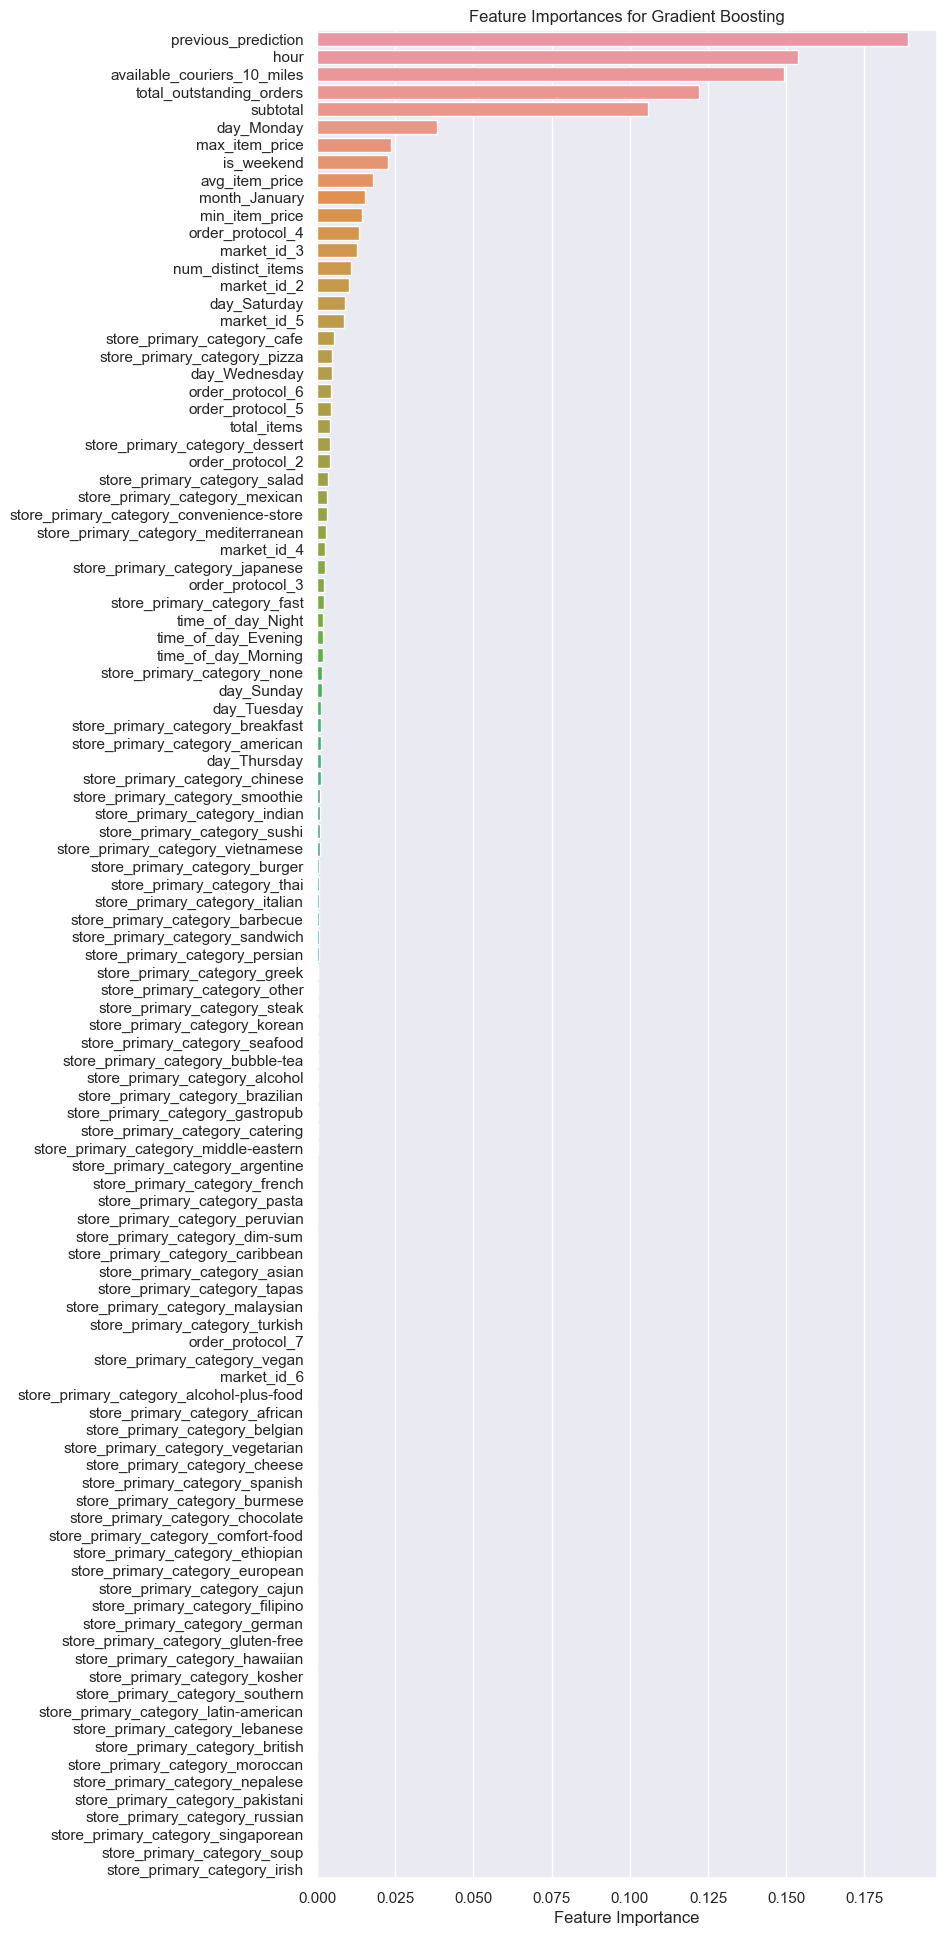

In [50]:
data = list(zip(X.columns, gradient.feature_importances_))
importance_df = pd.DataFrame(data, columns=["column_name", "value"]).sort_values("value", ascending=False)

plt.figure(figsize=(8, 24))
sns.barplot(x="value", y="column_name", data=importance_df)
plt.xlabel("Feature Importance")
plt.ylabel("")
plt.title("Feature Importances for Gradient Boosting")
plt.show();